# Entropy notebook (rewritten)

**Workflow**
1. Define entropy functions:
   - Sample entropy
   - Permutation entropy (Shannon)
   - Rényi permutation entropy
   - Conditional permutation entropy
   - Conditional Rényi permutation entropy
   - Bubble entropy (based on inversion-count distribution; efficient for small m)
2. Generate a synthetic signal 
3. Reproduce plots like the paper:
   - Entropy vs signal length *N* (linear and log x-axis)
   - Std/Mean vs *N*
   - Entropy vs embedding dimension *m*


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from math import factorial, log
from collections import Counter, defaultdict


## 1) Helper utilities


In [24]:
def _shannon_entropy_from_counts(counts, base=np.e):
    """Shannon entropy from a dict/Counter of counts."""
    total = sum(counts.values())
    if total == 0:
        return np.nan
    H = 0.0
    for c in counts.values():
        p = c / total
        if p > 0:
            H -= p * np.log(p)
    if base != np.e:
        H /= np.log(base)
    return H

def _renyi_entropy_from_counts(counts, alpha=2.0, base=np.e):
    """Rényi entropy from counts. alpha>0, alpha!=1."""
    total = sum(counts.values())
    if total == 0:
        return np.nan
    if abs(alpha - 1.0) < 1e-12:
        return _shannon_entropy_from_counts(counts, base=base)
    s = 0.0
    for c in counts.values():
        p = c / total
        s += p**alpha
    H = (1.0 / (1.0 - alpha)) * np.log(s)
    if base != np.e:
        H /= np.log(base)
    return H


## 2) Entropy definitions


In [23]:
def sample_entropy(x, m=2, r=None):
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N <= m + 1:
        return np.nan

    if r is None:
        r = 0.2 * np.std(x)

    def _count_matches(mm):
        xm = np.array([x[i:i+mm] for i in range(N - mm + 1)])
        count = 0
        for i in range(len(xm)-1):
            #  distance to following vectors
            dist = np.max(np.abs(xm[i+1:] - xm[i]), axis=1)
            count += np.sum(dist <= r)
        return count

    B = _count_matches(m)
    A = _count_matches(m + 1)

    if B == 0 or A == 0:
        return np.inf 
    return -np.log(A / B)


In [4]:
def permutation_entropy(x, m=3, tau=1, normalize=True, base=np.e):
    """
    Permutation entropy (Shannon) of order m and delay tau.

    If normalize=True, divide by log(m!) so the result is in [0, 1] (approximately).
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N < (m - 1) * tau + 1:
        return np.nan

    patterns = []
    for i in range(N - (m - 1) * tau):
        window = x[i : i + m * tau : tau]
        # mergesort for stable handling of ties
        order = np.argsort(window, kind="mergesort")
        patterns.append(tuple(order))

    counts = Counter(patterns)
    H = _shannon_entropy_from_counts(counts, base=base)
    if normalize:
        H /= np.log(factorial(m)) / (1 if base == np.e else np.log(base))
    return H


In [25]:
def renyi_permutation_entropy(x, m=3, tau=1, alpha=2.0, normalize=True, base=np.e):
    """
    Rényi permutation entropy of order m and delay tau.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N < (m - 1) * tau + 1:
        return np.nan

    patterns = []
    for i in range(N - (m - 1) * tau):
        window = x[i : i + m * tau : tau]
        order = np.argsort(window, kind="mergesort")
        patterns.append(tuple(order))

    counts = Counter(patterns)
    H = _renyi_entropy_from_counts(counts, alpha=alpha, base=base)
    if normalize:
        H /= np.log(factorial(m)) / (1 if base == np.e else np.log(base))
    return H


In [27]:
def conditional_permutation_entropy(x, m=3, tau=1, normalize=True, base=np.e):
    """
    Conditional permutation entropy: H(OP_t | OP_{t-1}).

    Computed from counts of consecutive ordinal patterns.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    L = N - (m - 1) * tau
    if L < 2:
        return np.nan

    pats = []
    for i in range(L):
        window = x[i : i + m * tau : tau]
        pats.append(tuple(np.argsort(window, kind="mergesort")))

    joint = Counter(zip(pats[1:], pats[:-1]))  # (current, prev)
    prev_counts = Counter(pats[:-1])

    H = 0.0
    total = sum(joint.values())
    for (cur, prev), c in joint.items():
        p_prev = prev_counts[prev] / (len(pats)-1)
        p_joint = c / total
        p_cond = p_joint / p_prev if p_prev > 0 else 0.0
        if p_cond > 0:
            H -= p_joint * np.log(p_cond)

    if base != np.e:
        H /= np.log(base)

    if normalize:
        H /= np.log(factorial(m)) / (1 if base == np.e else np.log(base))
    return H


In [28]:
def conditional_renyi_permutation_entropy(x, m=3, tau=1, alpha=2.0, normalize=True, base=np.e):
    """
    Conditional Rényi permutation entropy using:
      Hα(X|Y) = (1/(1-α)) * log( sum_y p(y) * sum_x p(x|y)^α )

    Here X = OP_t, Y = OP_{t-1}.
    """
    x = np.asarray(x, dtype=float)
    N = len(x)
    L = N - (m - 1) * tau
    if L < 2:
        return np.nan
    if abs(alpha - 1.0) < 1e-12:
        return conditional_permutation_entropy(x, m=m, tau=tau, normalize=normalize, base=base)

    pats = []
    for i in range(L):
        window = x[i : i + m * tau : tau]
        pats.append(tuple(np.argsort(window, kind="mergesort")))

    trans = defaultdict(Counter)
    prev_counts = Counter(pats[:-1])
    for prev, cur in zip(pats[:-1], pats[1:]):
        trans[prev][cur] += 1

    total_prev = sum(prev_counts.values())
    S = 0.0
    for prev, cprev in prev_counts.items():
        p_prev = cprev / total_prev
        row = trans[prev]
        row_total = sum(row.values())
        if row_total == 0:
            continue
        s_row = 0.0
        for c in row.values():
            p_cond = c / row_total
            s_row += p_cond**alpha
        S += p_prev * s_row

    H = (1.0 / (1.0 - alpha)) * np.log(S)
    if base != np.e:
        H /= np.log(base)

    if normalize:
        H /= np.log(factorial(m+1)) / (1 if base == np.e else np.log(base))
    return H


### Bubble entropy (inversion-count based)


In [111]:
import numpy as np
from collections import Counter



def _initial_inversions(window):
    """
    Initial inversion count for a 1D array 'window' using stable tie-breaking:
    inversion if i<j and window[i] > window[j]. (Equal values do NOT count.)
    O(m^2), used once per series.
    """
    inv = 0
    m = len(window)
    for i in range(m):
        wi = window[i]
        for j in range(i + 1, m):
            if wi > window[j]:
                inv += 1
    return inv


def _sliding_inversion_counts_tau1(x, m):
    x = np.asarray(x, dtype=float)
    N = len(x)
    L = N - m + 1
    if L <= 0:
        return []

    # Current window values
    w = x[:m].copy()
    inv = _initial_inversions(w)
    invs = [inv]

    for i in range(1, L):
        out = w[0]

        inv -= int(np.sum(out > w[1:]))

        # Slide window values left by one
        w[:-1] = w[1:]
        new = x[i + m - 1]
        w[-1] = new

        # Add inversions contributed by the new last element:
        inv += int(np.sum(w[:-1] > new))

        invs.append(inv)

    return invs


def bubble_entropy(x, m=10, tau=1, base=np.e):
   
    x = np.asarray(x, dtype=float)
    N = len(x)
    if N < m * tau + 1:  
        return np.nan

    def H_inv(mm):
        if tau == 1:
            inv_list = _sliding_inversion_counts_tau1(x, mm)
        else:
            L = N - (mm - 1) * tau
            if L <= 0:
                return np.nan
            inv_list = []
            for i in range(L):
                window = x[i : i + mm * tau : tau]
                inv_list.append(_initial_inversions(window))

        if len(inv_list) == 0:
            return np.nan
        counts = Counter(inv_list)
        return _renyi_entropy_from_counts(counts, alpha=2.0, base=base) 


    Hm = H_inv(m)
    Hm1 = H_inv(m + 1)
    return (Hm1 - Hm) / np.log((m + 1) / (m - 1))

## 3) Synthetic signal (logistic map)


In [112]:
import wfdb
def get_rr_from_physionet(db_name, record_name, ann_ext="atr", pn_dir=None):
    """
    Returns RR intervals (seconds) from beat annotations.
    Works with PhysioNet-style annotation files.
    """
    ann = wfdb.rdann(record_name, extension=ann_ext, pn_dir=pn_dir)
    samples = np.asarray(ann.sample, dtype=np.int64)

    hdr = wfdb.rdheader(record_name, pn_dir=pn_dir)
    fs = float(hdr.fs)

    rr = np.diff(samples) / fs
    rr = rr[np.isfinite(rr)]
    
    rr = rr[(rr > 0.2) & (rr < 2.5)]
    return rr


In [113]:
pn_dir = "nsr2db"

rec = "nsr001"

rr = get_rr_from_physionet("nsr2db", rec, ann_ext="ecg", pn_dir=pn_dir)
print("RR length:", len(rr), "mean:", rr.mean(), "std:", rr.std())


RR length: 106639 mean: 0.7588229183272537 std: 0.17075205755813258


In [114]:
def fit_ar_yule_walker(x, M):
    """
    Fit AR(M): x[n] = -sum_{i=1..M} a[i]*x[n-i] + w[n]
    Returns phi (length M) and sigma2 (noise variance).
    """
    x = np.asarray(x, dtype=float)
    x = x - np.mean(x)

    N = len(x)
    if N <= M + 5:
        raise ValueError("Too few samples to fit AR model.")

    r = np.array([np.dot(x[:N-k], x[k:]) / N for k in range(M+1)], dtype=float)

    # yule walker
    R = np.empty((M, M), dtype=float)
    for i in range(M):
        for j in range(M):
            R[i, j] = r[abs(i-j)]

    rhs = -r[1:]  
    phi = np.linalg.solve(R, rhs)

    # noise 
    sigma2 = r[0] + np.dot(phi, r[1:])
    sigma2 = float(max(sigma2, 1e-12))
    return phi, sigma2


In [115]:
def generate_ar_signal(N, phi, sigma2, burn_in=200, rng=None):
    """
    Generate AR signal:
      x[n] = -sum_{i=1..M} phi[i-1]*x[n-i] + w[n], w ~ N(0, sigma2)
    """
    if rng is None:
        rng = np.random.default_rng()

    phi = np.asarray(phi, dtype=float)
    M = len(phi)

    w = rng.normal(0.0, np.sqrt(sigma2), size=N + burn_in)
    x = np.zeros(N + burn_in, dtype=float)

    for n in range(M, N + burn_in):
        x[n] = -np.dot(phi, x[n-M:n][::-1]) + w[n]

    return x[burn_in:]


In [116]:
pn_dir = "nsr2db"
rec = "nsr001"

rr = get_rr_from_physionet("nsr2db", rec, ann_ext="ecg", pn_dir=pn_dir)

# AR order 
M = 16
phi, sigma2 = fit_ar_yule_walker(rr, M)

print("AR order:", M)
print("sigma2:", sigma2)
print("phi[:5]:", phi[:5])


AR order: 16
sigma2: 0.0013327296870786383
phi[:5]: [-0.72303111  0.07122374 -0.11360557 -0.17183611  0.00884624]


In [ ]:
MC = 200
tau = 1
alpha = 2.0

N_values = np.array([100, 200, 400, 800, 1600, 3200, 6400, 10000, 20000, 40000], dtype=int)

m_map_fig2 = {
    "SampleEn": 2,
    "PermEn": 10,
    "RPermEn": 10,
    "CondPermEn": 5,
    "CondRPermEn": 5,
    "BubbleEn": 10,
}

def r_sampen(x):
    return 0.20 * np.std(x, ddof=0)

entropy_fns_fig2 = {
    "SampleEn": lambda x: sample_entropy(x, m=m_map_fig2["SampleEn"], r=r_sampen(x)),
    "PermEn":   lambda x: permutation_entropy(x, m=m_map_fig2["PermEn"], tau=tau, normalize=False),
    "RPermEn":  lambda x: renyi_permutation_entropy(x, m=m_map_fig2["RPermEn"], tau=tau, alpha=alpha, normalize=True),
    "CondPermEn":  lambda x: conditional_permutation_entropy(x, m=m_map_fig2["CondPermEn"], tau=tau, normalize=False),
    "CondRPermEn": lambda x: conditional_renyi_permutation_entropy(x, m=m_map_fig2["CondRPermEn"], tau=tau, alpha=alpha, normalize=False),
    "BubbleEn":    lambda x: bubble_entropy(x, m=m_map_fig2["BubbleEn"], tau=tau),
}

rng = np.random.default_rng(0)

means_N = {k: np.full(len(N_values), np.nan) for k in entropy_fns_fig2}
stds_N  = {k: np.full(len(N_values), np.nan) for k in entropy_fns_fig2}

for iN, N in enumerate(N_values):
    vals = {k: [] for k in entropy_fns_fig2}
    for _ in range(MC):
        x = generate_ar_signal(N, phi, sigma2, burn_in=200, rng=rng)
        for name, f in entropy_fns_fig2.items():
            try:
                vals[name].append(f(x))
            except Exception:
                vals[name].append(np.nan)

    for name in entropy_fns_fig2:
        arr = np.asarray(vals[name], dtype=float)
        means_N[name][iN] = np.nanmean(arr)
        stds_N[name][iN]  = np.nanstd(arr)



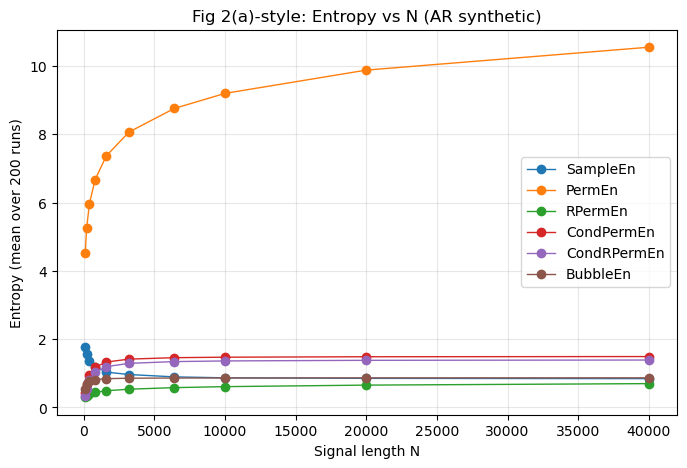

In [129]:
plt.figure(figsize=(8,5))
for name in entropy_fns_fig2:
    plt.plot(N_values, means_N[name], marker='o', linewidth=1, label=name)
plt.xlabel("Signal length N")
plt.ylabel(f"Entropy (mean over {MC} runs)")
plt.title("Fig 2(a)-style: Entropy vs N (AR synthetic)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


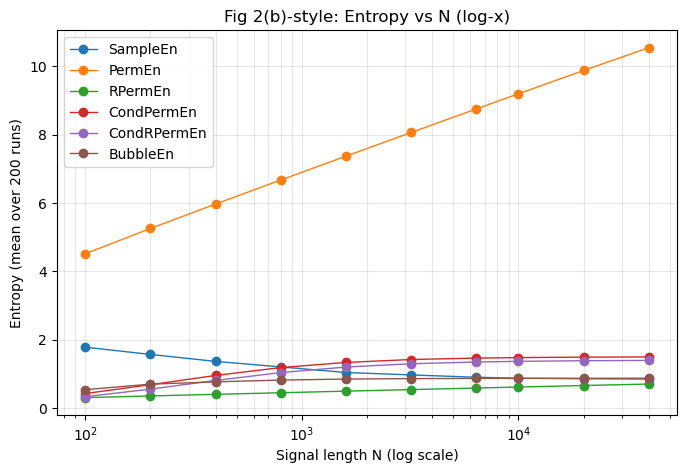

In [130]:
plt.figure(figsize=(8,5))
for name in entropy_fns_fig2:
    plt.plot(N_values, means_N[name], marker='o', linewidth=1, label=name)
plt.xscale("log")
plt.xlabel("Signal length N (log scale)")
plt.ylabel(f"Entropy (mean over {MC} runs)")
plt.title("Fig 2(b)-style: Entropy vs N (log-x)")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()


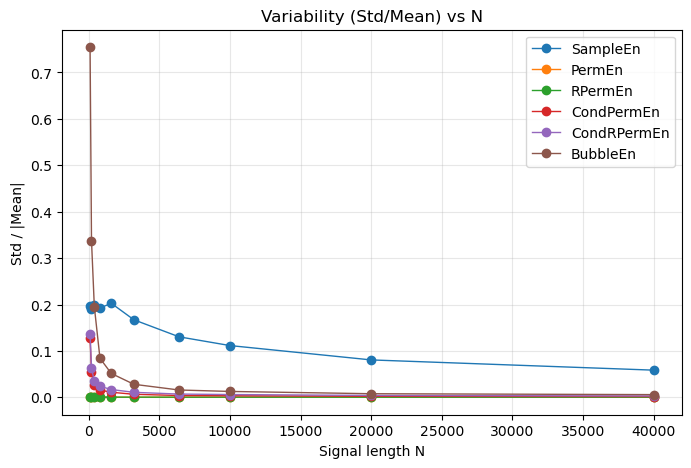

In [131]:

plt.figure(figsize=(8,5))
for name in entropy_fns_fig2:
    ratio = stds_N[name] / np.maximum(np.abs(means_N[name]), 1e-12)
    plt.plot(N_values, ratio, marker='o', linewidth=1, label=name)
plt.xlabel("Signal length N")
plt.ylabel("Std / |Mean|")
plt.title("Variability (Std/Mean) vs N")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [ ]:
MC_m = 200
N_m = 1000  
m_values = np.arange(2, 26)

entropy_fns_m = {
    "SampleEn": lambda x, m: sample_entropy(x, m=m, r=0.20*np.std(x, ddof=0)),
    "PermEn":   lambda x, m: permutation_entropy(x, m=m, tau=tau, normalize=False),
    "RPermEn":  lambda x, m: renyi_permutation_entropy(x, m=m, tau=tau, alpha=alpha, normalize=False),
    "CondPermEn":  lambda x, m: conditional_permutation_entropy(x, m=m, tau=tau, normalize=False),
    "CondRPermEn": lambda x, m: conditional_renyi_permutation_entropy(x, m=m, tau=tau, alpha=alpha, normalize=False),
    "BubbleEn":    lambda x, m: bubble_entropy(x, m=m, tau=tau),
}

rng = np.random.default_rng(1)
means_m = {k: np.full(len(m_values), np.nan) for k in entropy_fns_m}

for i, m in enumerate(m_values):
    vals = {k: [] for k in entropy_fns_m}
    for _ in range(MC_m):
        x = generate_ar_signal(N_m, phi, sigma2, burn_in=200, rng=rng)
        for name, f in entropy_fns_m.items():
            try:
                vals[name].append(f(x, m))
            except Exception:
                vals[name].append(np.nan)
    for name in entropy_fns_m:
        means_m[name][i] = np.nanmean(np.asarray(vals[name], float))


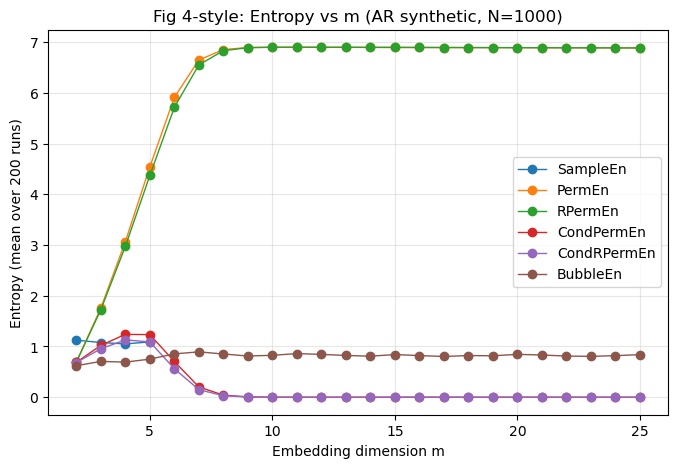

In [133]:
plt.figure(figsize=(8,5))
for name in entropy_fns_m:
    plt.plot(m_values, means_m[name], marker='o', linewidth=1, label=name)
plt.xlabel("Embedding dimension m")
plt.ylabel(f"Entropy (mean over {MC_m} runs)")
plt.title(f"Fig 4-style: Entropy vs m (AR synthetic, N={N_m})")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [134]:
import wfdb
import numpy as np

nsr_records = wfdb.get_record_list("nsr2db")
chf_records = wfdb.get_record_list("chf2db")

print("NSR records:", len(nsr_records))
print("CHF records:", len(chf_records))
print("Example NSR:", nsr_records[:5])
print("Example CHF:", chf_records[:5])


NSR records: 54
CHF records: 29
Example NSR: ['nsr001', 'nsr002', 'nsr003', 'nsr004', 'nsr005']
Example CHF: ['chf201', 'chf202', 'chf203', 'chf204', 'chf205']


In [135]:
def get_rr_intervals(db_name, rec_name, ann_ext="atr"):
    """
    RR intervals (seconds) from beat annotations.
    """
    ann = wfdb.rdann(rec_name, extension=ann_ext, pn_dir=db_name)
    samples = np.asarray(ann.sample, dtype=np.int64)

    hdr = wfdb.rdheader(rec_name, pn_dir=db_name)
    fs = float(hdr.fs)

    rr = np.diff(samples) / fs
    rr = rr[np.isfinite(rr)]
    # filter unrealistic values 
    rr = rr[(rr > 0.2) & (rr < 2.5)]
    return rr

def middle_segment(rr, N=1000):
    """
    Take N RR intervals from the middle of the recording.
    Returns None if too short.
    """
    rr = np.asarray(rr, dtype=float)
    if len(rr) < N:
        return None
    start = (len(rr) - N) // 2
    return rr[start:start+N]


In [140]:
N_RR = 300

nsr_rr = []
chf_rr = []

skipped_nsr = []
skipped_chf = []

for rec in nsr_records:
    try:
        rr = get_rr_intervals("nsr2db", rec, ann_ext="ecg")
        seg = middle_segment(rr, N=N_RR)
        if seg is None:
            skipped_nsr.append(rec)
        else:
            nsr_rr.append(seg)
    except Exception as e:
        skipped_nsr.append(rec)

for rec in chf_records:
    try:
        rr = get_rr_intervals("chf2db", rec, ann_ext="ecg")
        seg = middle_segment(rr, N=N_RR)
        if seg is None:
            skipped_chf.append(rec)
        else:
            chf_rr.append(seg)
    except Exception as e:
        skipped_chf.append(rec)

print("NSR usable:", len(nsr_rr), "skipped:", len(skipped_nsr))
print("CHF usable:", len(chf_rr), "skipped:", len(skipped_chf))


NSR usable: 54 skipped: 0
CHF usable: 29 skipped: 0


In [141]:
import numpy as np

N_BOX = 300  

def take_first_N(rr, N=N_BOX):
    rr = np.asarray(rr, float)
    if len(rr) < N:
        return None
    x = rr[:N].copy()
    if not np.all(np.isfinite(x)):
        return None
    return x

nsr_seg = [take_first_N(rr, N_BOX) for rr in nsr_rr]
chf_seg = [take_first_N(rr, N_BOX) for rr in chf_rr]

nsr_seg = [x for x in nsr_seg if x is not None]
chf_seg = [x for x in chf_seg if x is not None]

print("Segments kept | NSR:", len(nsr_seg), "CHF:", len(chf_seg), "N=", N_BOX)
print("Example NSR head:", nsr_seg[0][:8])
print("Example CHF head:", chf_seg[0][:8])


Segments kept | NSR: 54 CHF: 29 N= 300
Example NSR head: [0.71875   0.75      0.7265625 0.7265625 0.7265625 0.71875   0.734375
 0.71875  ]
Example CHF head: [0.78125   0.7734375 0.7734375 0.796875  0.8046875 0.78125   0.765625
 0.7734375]


In [142]:
from scipy.stats import ttest_ind

tau = 1
alpha = 2.0

def compute_over_subjects(rr_list, func):
    out = []
    for x in rr_list:
        try:
            v = func(x)
        except Exception:
            v = np.nan
        out.append(v)
    return np.asarray(out, dtype=float)

def p_from(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    a = a[np.isfinite(a)]
    b = b[np.isfinite(b)]
    if len(a) < 2 or len(b) < 2:
        return np.nan
    return ttest_ind(a, b, equal_var=False).pvalue


/var/folders/xg/_gjkllk906lcrzt4_k6qmmf40000gr/T/ipykernel_55997/1052884034.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  return (Hm1 - Hm) / np.log((m + 1) / (m - 1))
/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


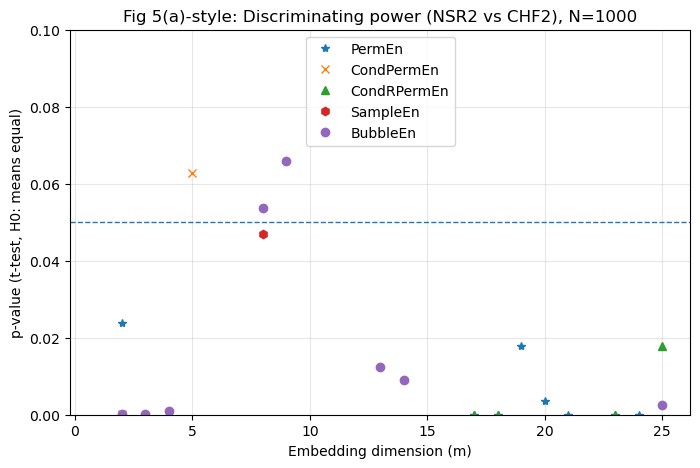

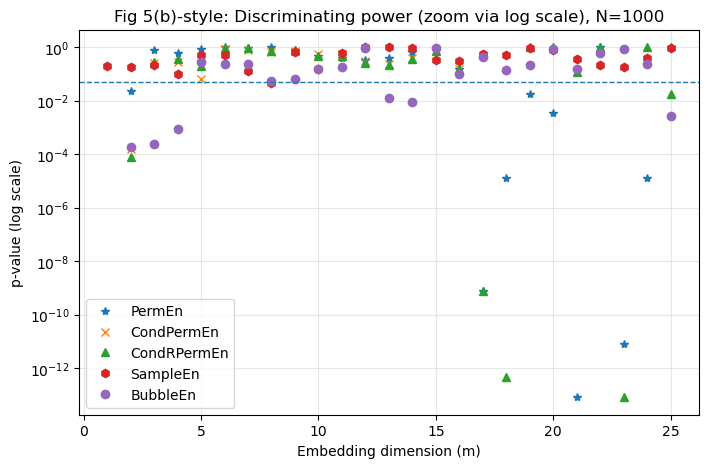

In [146]:
import matplotlib.pyplot as plt

m_values = np.arange(0, 26)

def perm_en_m(m):
    return lambda x: permutation_entropy(x, m=m, tau=tau, normalize=False)

def cond_perm_en_m(m):
    return lambda x: conditional_permutation_entropy(x, m=m, tau=tau, normalize=False)

def cond_renyi_perm_en_m(m):
    return lambda x: conditional_renyi_permutation_entropy(x, m=m, tau=tau, alpha=alpha, normalize=False)

def bubble_en_m(m):
    return lambda x: bubble_entropy(x, m=m, tau=tau)

def sampen_m(m):
    def f(x):
        r = 0.2 * np.std(x, ddof=0)
        return sample_entropy(x, m=m, r=r)
    return f

pvals = {k: [] for k in ["PermEn","CondPermEn","CondRPermEn","SampleEn","BubbleEn"]}

for m in m_values:
    nsr_pe  = compute_over_subjects(nsr_seg, perm_en_m(m))
    chf_pe  = compute_over_subjects(chf_seg, perm_en_m(m))

    nsr_cpe = compute_over_subjects(nsr_seg, cond_perm_en_m(m))
    chf_cpe = compute_over_subjects(chf_seg, cond_perm_en_m(m))

    nsr_crp = compute_over_subjects(nsr_seg, cond_renyi_perm_en_m(m))
    chf_crp = compute_over_subjects(chf_seg, cond_renyi_perm_en_m(m))

    nsr_ben = compute_over_subjects(nsr_seg, bubble_en_m(m))
    chf_ben = compute_over_subjects(chf_seg, bubble_en_m(m))

    nsr_se  = compute_over_subjects(nsr_seg, sampen_m(m))
    chf_se  = compute_over_subjects(chf_seg, sampen_m(m))

    pvals["PermEn"].append(p_from(nsr_pe,  chf_pe))
    pvals["CondPermEn"].append(p_from(nsr_cpe, chf_cpe))
    pvals["CondRPermEn"].append(p_from(nsr_crp, chf_crp))
    pvals["BubbleEn"].append(p_from(nsr_ben, chf_ben))
    pvals["SampleEn"].append(p_from(nsr_se,  chf_se))

plt.figure(figsize=(8,5))
plt.plot(m_values, pvals["PermEn"],      marker="*", linestyle="None", label="PermEn")
plt.plot(m_values, pvals["CondPermEn"],  marker="x", linestyle="None", label="CondPermEn")
plt.plot(m_values, pvals["CondRPermEn"], marker="^", linestyle="None", label="CondRPermEn")
plt.plot(m_values, pvals["SampleEn"],    marker="h", linestyle="None", label="SampleEn")
plt.plot(m_values, pvals["BubbleEn"],    marker="o", linestyle="None", label="BubbleEn")
plt.axhline(0.05, linestyle="--", linewidth=1)

plt.xlabel("Embedding dimension (m)")
plt.ylabel("p-value (t-test, H0: means equal)")
plt.title("Fig 5(a)-style: Discriminating power (NSR2 vs CHF2), N=1000")
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, 0.1)  
plt.show()

plt.figure(figsize=(8,5))
for k, mk in [("PermEn","*"),("CondPermEn","x"),("CondRPermEn","^"),("SampleEn","h"),("BubbleEn","o")]:
    y = np.array(pvals[k], float)
    plt.plot(m_values, y, marker=mk, linestyle="None", label=k)
plt.axhline(0.05, linestyle="--", linewidth=1)
plt.yscale("log")
plt.xlabel("Embedding dimension (m)")
plt.ylabel("p-value (log scale)")
plt.title("Fig 5(b)-style: Discriminating power (zoom via log scale), N=1000")
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()


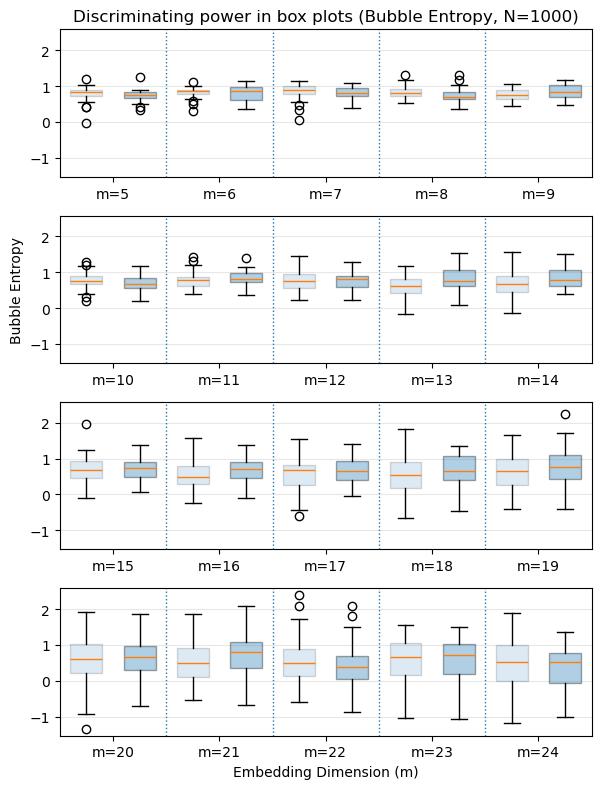

In [145]:
import matplotlib.pyplot as plt
import numpy as np

m_box = np.arange(5, 25) 

bubble_vals_nsr = {}
bubble_vals_chf = {}

for m in m_box:
    bubble_vals_nsr[m] = compute_over_subjects(nsr_seg, lambda x, mm=m: bubble_entropy(x, m=mm, tau=tau))
    bubble_vals_chf[m] = compute_over_subjects(chf_seg, lambda x, mm=m: bubble_entropy(x, m=mm, tau=tau))

rows = [(5,9),(10,14),(15,19),(20,24)]
fig, axes = plt.subplots(len(rows), 1, figsize=(6, 8), sharey=True)

if len(rows) == 1:
    axes = [axes]

for ax, (a, b) in zip(axes, rows):
    ms = list(range(a, b+1))

    positions = []
    data = []
    labels = []
    for i, m in enumerate(ms):
        p0 = 2*i + 1
        p1 = 2*i + 2
        
        # CHF
        data.append(bubble_vals_chf[m][np.isfinite(bubble_vals_chf[m])])
        positions.append(p1)
        # NSR
        data.append(bubble_vals_nsr[m][np.isfinite(bubble_vals_nsr[m])])
        positions.append(p0)

        labels.append(f"m={m}")

        if m != ms[-1]:
            ax.axvline(p1 + 0.5, linestyle=":", linewidth=1)

    bp = ax.boxplot(data, positions=positions, widths=0.6, patch_artist=True, showfliers=True)

    for j, box in enumerate(bp["boxes"]):
        if j % 2 == 0:   # NSR
            box.set_alpha(0.35)
        else:            # CHF
            box.set_alpha(0.15)

    centers = [2*i + 1.5 for i in range(len(ms))]
    ax.set_xticks(centers)
    ax.set_xticklabels(labels)
    ax.grid(True, axis="y", alpha=0.3)

axes[0].set_title("Discriminating power in box plots (Bubble Entropy, N=1000)")
axes[1].set_ylabel("Bubble Entropy")
axes[-1].set_xlabel("Embedding Dimension (m)")
plt.tight_layout()
plt.show()
